# **<center><font style="color:rgb(100,109,254)">Module 4: Creating a Full-Fledge Exercise Monitoring System</font> </center>**

<center><img src='https://drive.google.com/uc?export=download&id=1w8i5LvA4kwUINJHcCuHJY_Blb6FzFN_3' width=800> </center>    


## **<font style="color:rgb(134,19,348)"> Module Outline </font>**

The module can be split into the following parts:

- *Lesson 1: Introduction to Pose Landmarks Detection Theory*

- ***Lesson 2:* Create a Pose Landmarks Detector** *(This Tutorial)*

- *Lesson 3: Compute Angles between Body Joints*

- *Lesson 4: Build the Final Application*

**Please Note**, these Jupyter Notebooks are not for sharing; do read the Copyright message below the Code License Agreement section which is in the last cell of this notebook.
-Taha Anwar

Alright, let's get started.

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

First, we will import the required libraries.

In [1]:
import cv2
import numpy as np
import mediapipe as mp
from time import time
import matplotlib.pyplot as plt
from importlib.metadata import version
print(f"Mediapipe version: {version('mediapipe')}, it should be 0.8.9.1")

Mediapipe version: 0.8.9.1, it should be 0.8.9.1


**Note:** Activate your working environment and then uninstall the old mediapipe library, and install the latest mediapipe version, you can then start this kernel and check the version of mediapipe by running the cell above.

In [2]:
# Make sure jupyterlab is running on your desired environment.
import sys
sys.executable.split('/')

['', 'opt', 'anaconda3', 'bin', 'python']

## **<font style="color:rgb(134,19,348)">Initialize the Pose Detection Model</font>**

To use the Mediapipe's Pose Detection solution, we first have to initialize the pose class using the syntax **`mp.solutions.pose`** and then we will have to call the function **`mp.solutions.pose.Pose()`** with the arguments explained below:

* **`static_image_mode`** - It is a boolean value that is if set to `False`, the solution treats the input images as a video stream. It will try to detect the most prominent person in the very first images, and upon a successful detection further localizes the pose landmarks. In subsequent images, it then simply tracks those landmarks without invoking another detection until it loses track, which reduces computation and latency. If set to `True`, person detection runs every input image, ideal for processing a batch of static, possibly unrelated, images. Its default value is `False`.

* **`model_complexity`** - It is the complexity of the pose landmark model. As there are three different models to choose from so the possible values for the **`model_complexity`** are `0`, `1`, or `2`. The higher the value, the more accurate the results are, but at the expense of higher latency. Its default value is `1`.

* **`smooth_landmarks`** - It is a boolean value that is if set to `True`, the solution filters pose landmarks across different input images to reduce jitter (noise), but ignored if **`static_image_mode`** is also set to `True`. Its default value is `True`.

* **`enable_segmentation`** - It is a boolean value that is if set to `True`, in addition to the pose landmarks the solution also generates the segmentation mask. Its default value is `False`.

* **`smooth_segmentation`** - It is a boolean value that is if set to `True`, the solution filters segmentation masks across different input images to reduce jitter. Ignored if **`enable_segmentation`** is `False` or **`static_image_mode`** is `True`. Its default value is `True`.

* **`min_detection_confidence`** - It is the minimum detection confidence with range `([0.0 , 1.0])` required to consider the person-detection model's prediction correct. Its default value is `0.5`. This means if the detector has a prediction confidence of greater or equal to 50% then it will be considered as a positive detection.

* **`min_tracking_confidence`** - It is the minimum tracking confidence `([0.0, 1.0])` required to consider the landmark-tracking model's tracked pose landmarks valid. If the confidence is less than the set value then the detector is invoked again in the next frame/image, so increasing its value increases the robustness, but also increases the latency. Its default value is `0.5`.

We will be working with images and videos as well, so we will have to set up the **`mp.solutions.pose.Pose()`** function two times. Once with the argument **`static_image_mode`** set to `True` to use with images and the second time **`static_image_mode`** set to `False` to use with videos. We will also need to initialize the **`mp.solutions.drawing_utils`** class and the **`mp.solutions.drawing_styles`** class that will allow us to visualize the pose landmarks on the images/frames.

In [3]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Set up the pose landmarks function for images.
pose_images = mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=True,
                           min_detection_confidence=0.8)

# Set up the pose landmarks function for videos.
pose_videos = mp_pose.Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True,
                           enable_segmentation=True, smooth_segmentation=True, 
                           min_detection_confidence=0.5, min_tracking_confidence=0.8)

# Initialize the mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils

# Initialize the mediapipe drawing styles class.
mp_drawing_styles = mp.solutions.drawing_styles

## **<font style="color:rgb(134,19,348)">Create a Pose Landmarks Detection Function</font>**

Now similar to what we had done in the previous modules for the Face and hands' landmarks detection, we will create a function **`detectPoseLandmarks()`** that will perform Pose landmarks detection on an image and will visualize the resultant image along with the original image (using the [**`matplotlib`**](https://matplotlib.org/stable/index.html) library) or return the resultant image along with the output of the model depending upon the passed arguments.

To perform the Pose landmarks detection, we will pass the image to the landmarks detection machine learning pipeline by using the function **`mp.solutions.pose.Pose().process()`**. But first, we will have to convert the image from **`BGR`** to **`RGB`** format using the function [**`cv2.cvtColor()`**](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) as OpenCV reads images in **`BGR`** format and the ml pipeline expects the input images to be in **`RGB`** color format.

The machine learning pipeline outputs an object that has an attribute **`pose_landmarks`** that contains the **33 3D** pose landmarks for the most prominent person in the image. Each landmark has:

* **`x`** - It is the landmark x-coordinate normalized to [0.0, 1.0] by the image width.


* **`y`**: It is the landmark y-coordinate normalized to [0.0, 1.0] by the image height.


* **`z`**: It is the landmark z-coordinate normalized to roughly the same scale as **`x`**. It represents the landmark depth with the midpoint of hips being the origin, so the smaller the value of z, the closer the landmark is to the camera. 


* **`visibility`**: It is a value with range [0.0, 1.0] representing the possibility of the landmark being visible (not occluded) in the image. This is a useful variable when deciding if you want to show a particular joint because it might be occluded or partially visible in the image.

**Note:** *The z-coordinate is just the relative distance of the landmark from the center of the hips, and this distance increases and decreases depending upon the distance from the camera so that is why it represents the depth of each landmark point.*

The image below shows the **thirty-three** body landmarks, that this solution detects, along with their indexes. 

<center> 
<img src='https://drive.google.com/uc?export=download&id=1CDO0KiXZEOuWc7xLEm7EFLLQf2hydCoI' width = 600> 
</center>

We will draw the detected landmarks on a copy of the input image using the function **`mp.solutions.drawing_utils.draw_landmarks()`** from the class **`mp.solutions.drawing_utils`**, we had initialized earlier.

In [4]:
def detectPoseLandmarks(image, pose, draw=True, display=True):
    '''
    This function performs pose landmarks detection on an image.
    Args:
        image:   The input image with a prominent person whose pose landmarks needs to be detected.
        pose:    The Mediapipe's pose landmarks detection function required to perform the pose detection.
        draw:    A boolean value that is if set to true the function draws the detected landmarks on the output image. 
        display: A boolean value that is if set to true the function displays the original input image, the segmentation mask, 
                 the resultant image, and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image:   The input image with the detected pose landmarks drawn.
        pose_landmarks: An array containing the detected landmarks (x and y coordinates) converted into their original scale.
    '''
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Landmarks Detection on the image.
    results = pose.process(imageRGB)
    
    # Initialize a list to store the pose landmarks.
    pose_landmarks = []
    
    # Initialize a variable to store the segmentation mask.
    segmentation_mask = np.zeros(shape=(height, width), dtype=np.uint8)
    
    # Check if any landmarks are found.
    if results.pose_landmarks:
        
        # Get the segmentation mask of the person detected in the image.
        segmentation_mask = results.segmentation_mask
        
        # Convert the pose landmarks x and y coordinates into their original scale,
        # And store them into a numpy array.
        pose_landmarks = np.array([(landmark.x*width, landmark.y*height)
                                    for landmark in results.pose_landmarks.landmark], dtype=np.int32)
                
        # Check if pose landmarks are specified to be drawn.
        if draw:
            
            # Draw Pose landmarks on the output image.
            mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                      connections=mp_pose.POSE_CONNECTIONS, landmark_drawing_spec=mp_drawing_styles.
                                      get_default_pose_landmarks_style())
    
    # Check if the original input image, the segmentation mask, and the resultant image are specified to be displayed.
    if display:

        # Display the original input image, the segmentation mask, and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(131);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(132);plt.imshow(segmentation_mask, cmap='gray');plt.title("Segmentation Mask");plt.axis('off');
        plt.subplot(133);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');


        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

    # Otherwise
    else:

        # Return the output image and landmarks detected.
        return output_image, pose_landmarks

Now we will read a few sample images using the function [**`cv2.imread()`**](https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56) and then utilize the function **`detectPoseLandmarks()`** created above to perform Pose Landmarks Detection on the images and display the results.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


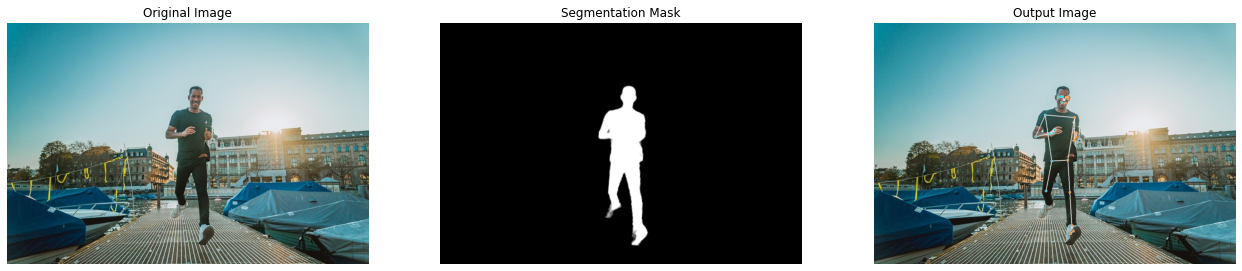

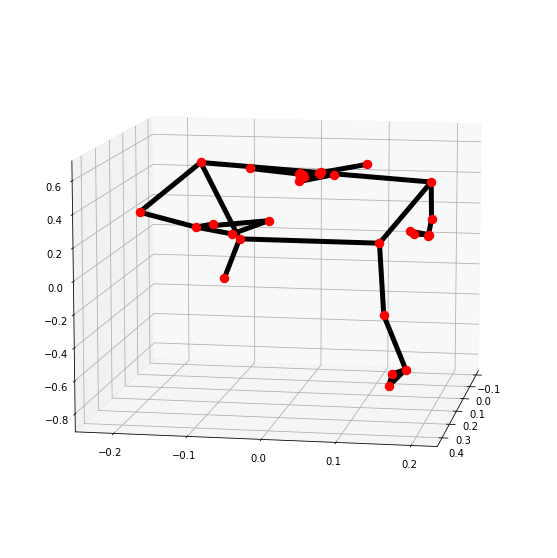

In [5]:
# Read a sample image and perform pose detection on it.
image = cv2.imread('media/sample1.jpg')
detectPoseLandmarks(image, pose_images, display=True)

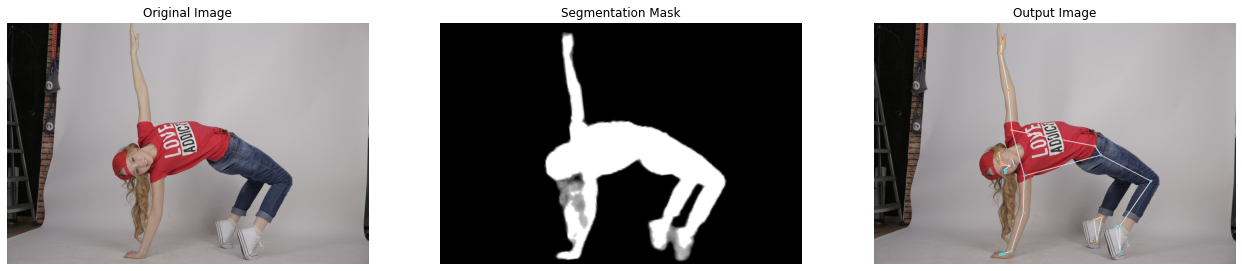

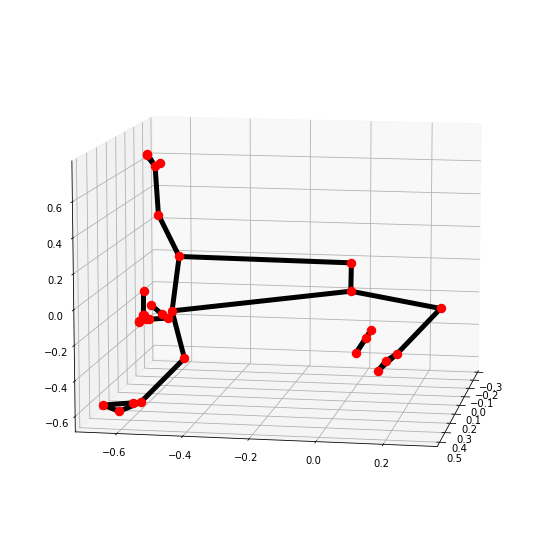

In [6]:
# Read another sample image and perform pose detection on it.
image = cv2.imread('media/sample2.jpg')
detectPoseLandmarks(image, pose_images, display=True)

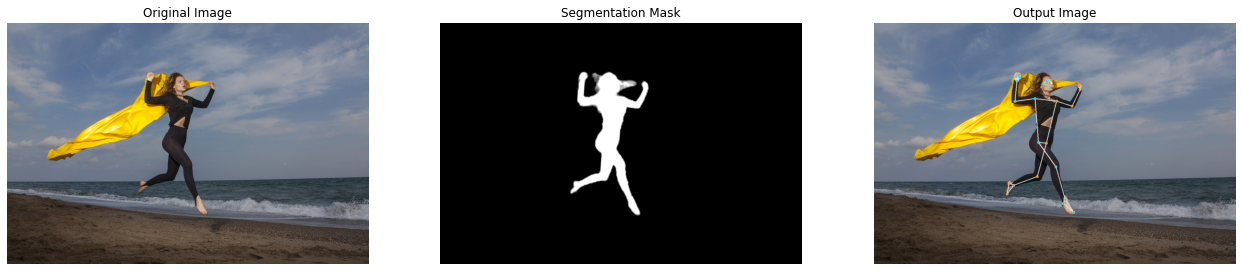

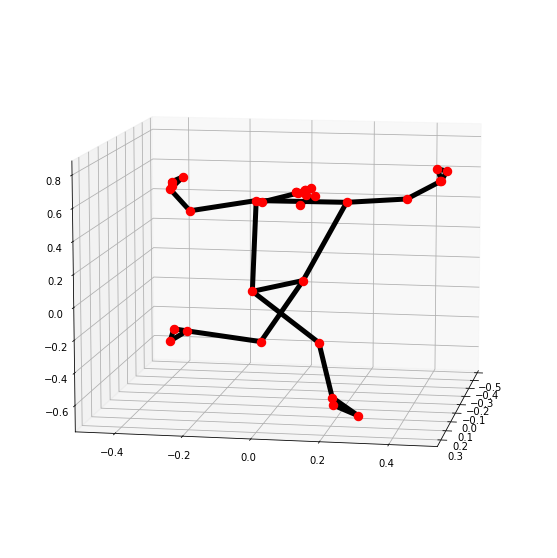

In [7]:
# Read another sample image and perform pose detection on it.
image = cv2.imread('media/sample3.jpg')
detectPoseLandmarks(image, pose_images, display=True)

Cool! Working quite accurately on images, now let's try it on a real-time webcam feed to get an idea of whether this solution can work in real-time on a CPU or not.

In [9]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Pose Landmarks Detection', cv2.WINDOW_NORMAL)

# Get the start time.
start_time = time()

# Initialize a variable to store the frame count.
frame_count = 0

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Increment the frame counter.
    frame_count += 1
        
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Perform Pose landmarks detection on the frame.
    frame, _ = detectPoseLandmarks(frame, pose_videos, display=False)
    
    # Calaculate average frames per second.
    ##################################################################################################
    
    # Get the current time.
    curr_time = time()
    
    # Check if the difference between the start and current time > 0 to avoid division by zero.
    if (curr_time - start_time) > 0:
    
        # Calculate the number of frames per second.
        frames_per_second = frame_count // (curr_time - start_time)
        
        # Write the calculated number of frames per second on the frame. 
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, int(frame_width/25)),
                    cv2.FONT_HERSHEY_PLAIN, int(frame_width/300), (0, 255, 0), int(frame_width/200))
    
    ##################################################################################################
           
    # Display the frame.
    cv2.imshow('Pose Landmarks Detection', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

### **<font style="color:rgb(255,140,0)"> Code License Agreement </font>**
```
Copyright (c) 2022 Bleedai.com

Feel free to use this code for your own projects commercial or noncommercial, these projects can be Research-based, just for fun, for-profit, or even Education with the exception that you’re not going to use it for developing a course, book, guide, or any other educational products.

Under *NO CONDITION OR CIRCUMSTANCE* you may use this code for your own paid educational or self-promotional ventures without written consent from Taha Anwar (BleedAI.com).

```
